#### Install and import the dependencies

In [23]:
!pip install -r requirements.txt --quiet

In [246]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import helpers
from scipy import stats
from datetime import datetime
from scipy.stats import norm
from sklearn.ensemble import IsolationForest
warnings.filterwarnings('ignore')
%matplotlib inline

#### Convert to HTML for GitHub Pages

`jupyter nbconvert --to html deliverable.ipynb --output index.html`

# Part 1

First, lets look at our data, and analyze any missing values

<!-- In "The Art of War", Sun Tzu, chinese philospher and military strategist, says: 

**"Know thy self, know thy enemy."**

As a data scientist, what I really think he meant was: 

**"Know thy data, know thy confounders."**
 -->

In [247]:
FILE_PATH = 'AML exercise - dataset.xlsx'
df = pd.read_excel(FILE_PATH)
df = df.drop(["Unnamed: 0"], axis = 1)
print("--------------------")
print(f"Shape: {df.shape}")
print("--------------------")
df.head()

--------------------
Shape: (11399, 25)
--------------------


,Send DateTime,Pay DateTime,Amount,Sender Name_,Sender Address_,Sender ID1 info,Sender City,Sender State,Payee Name_,Payee Address_,...,Send Agent State,Send Country,Send Operator Name_,Pay Agent Name_,Pay Agent City,Pay Agent State,Pay Country,Pay Operator Name_,Sender Age,Payee Age
0,12/26/2015 13:01,12/28/2015 9:19,990.0,name_1,address_1,1,PALO ALTO,CA,name_742,address_2615,...,CA,UNITED STATES,operator_name_3,agent_1,MORELIA,NaN,MEXICO,operator_name_0,40.0,NaN
1,12/28/2015 15:36,12/28/2015 19:15,690.0,name_2,address_2,0,SAN JOSE,CA,name_3020,address_2616,...,CA,UNITED STATES,operator_name_12,agent_2,MANZANILLO,NaN,MEXICO,operator_name_0,50.0,NaN
2,11/30/2015 20:55,12/1/2015 18:39,990.0,name_3,address_3,1,REDWOOD CITY,CA,name_3021,address_2617,...,CA,UNITED STATES,operator_name_3,agent_3,YANGA,NaN,MEXICO,operator_name_0,47.0,NaN
3,12/8/2015 15:33,12/8/2015 17:37,1000.0,name_4,address_4,1,SAN CARLOS,CA,name_2609,address_2618,...,CA,UNITED STATES,operator_name_12,agent_4,GUADALAJARA,NaN,MEXICO,operator_name_0,51.0,53.0
4,12/10/2015 14:48,12/10/2015 15:48,830.0,name_5,address_5,0,EAST PALO ALTO,CA,name_3022,address_2619,...,CA,UNITED STATES,operator_name_12,agent_5,SAN SALVADOR,NaN,EL SALVADOR,operator_name_0,49.0,NaN


In [248]:
df.columns

Index(['Send DateTime', 'Pay DateTime', 'Amount', 'Sender Name_',
       'Sender Address_', 'Sender ID1 info', 'Sender City', 'Sender State',
       'Payee Name_', 'Payee Address_', 'Payee ID1 info', 'Payee City',
       'Payee State', 'Send Agent Name_', 'Send Agent City',
       'Send Agent State', 'Send Country', 'Send Operator Name_',
       'Pay Agent Name_', 'Pay Agent City', 'Pay Agent State', 'Pay Country',
       'Pay Operator Name_', 'Sender Age', 'Payee Age'],
      dtype='object')

In [249]:
missing_data = helpers.describe_missing_data(df)
missing_data.head(20)

,Total,Percent
Payee State,7864,0.689885
Pay Agent State,7318,0.641986
Payee Age,3383,0.296780
Sender Age,2820,0.247390
Payee City,671,0.058865
Send Agent State,185,0.016229
Sender State,170,0.014914
Pay Country,11,0.000965
Pay DateTime,11,0.000965
Pay Agent City,11,0.000965


### Transaction Frequency and Time between Wire and Recieve

#### Sender Frequency

In [250]:
print(f"There are {len(df['Sender Name_'].unique())} unique senders")

There are 3019 unique senders


In [251]:
print(f"There are {len(df['Payee Name_'].unique())} unique recievers")

There are 4658 unique recievers


In [252]:
sender_freq = pd.DataFrame(df.groupby('Sender Name_').count()['Send DateTime']) #selecting 'Send DateTime' because there are no missing values
sender_freq.columns = ["sent_freq"]
len(sender_freq) == len(df['Sender Name_'].unique()) # ensure all values are captured

True

In [253]:
sender_freq.sort_values(by='sent_freq', ascending=False).head(10)

,sent_freq
Sender Name_,
name_10,301
name_104,95
name_45,92
name_234,74
name_1111,73
name_1337,70
name_119,67
name_134,64
name_115,64


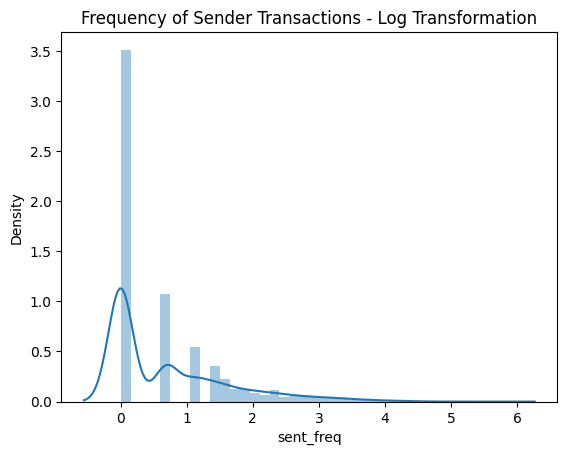

In [254]:
sns.distplot(np.log(sender_freq['sent_freq']))
plt.title("Frequency of Sender Transactions - Log Transformation"); #log transformation helps spread out the data 

In [255]:
payee_freq = pd.DataFrame(df.groupby('Payee Name_').count()['Send DateTime'])
payee_freq.columns = ["payee_freq"]
payee_freq.sort_values(by='payee_freq', ascending=False).head(10)

,payee_freq
Payee Name_,
name_3062,82
name_4344,70
name_3269,55
name_3298,53
name_5375,53
name_3281,52
name_4779,48
name_3756,44
name_4512,44


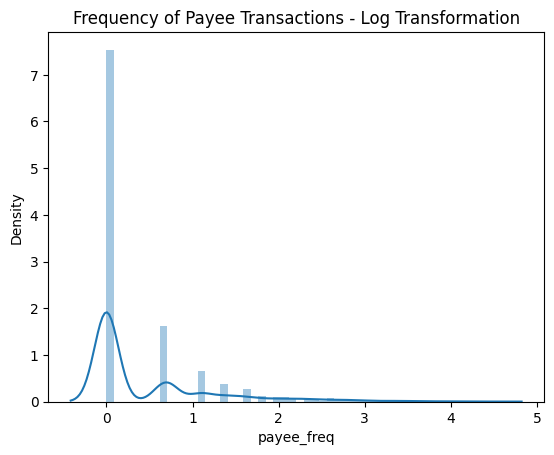

In [256]:
sns.distplot(np.log(payee_freq['payee_freq']))
plt.title("Frequency of Payee Transactions - Log Transformation");

### Send and Pay Agents

In [257]:
print(f"There are {len(df['Pay Agent Name_'].unique())} unique pay agents")

There are 2519 unique pay agents


In [258]:
print(f"There are {len(df['Send Agent Name_'].unique())} unique send agents")

There are 398 unique send agents


In [259]:
pay_agent_freq = pd.DataFrame(df.groupby('Pay Agent Name_').count()['Send DateTime'])
pay_agent_freq.columns = ['txn_freq']
pay_agent_freq.sort_values(by='txn_freq', ascending=False).head(5)

,txn_freq
Pay Agent Name_,
agent_11,966
agent_39,200
agent_73,182
agent_16,166
agent_6,153


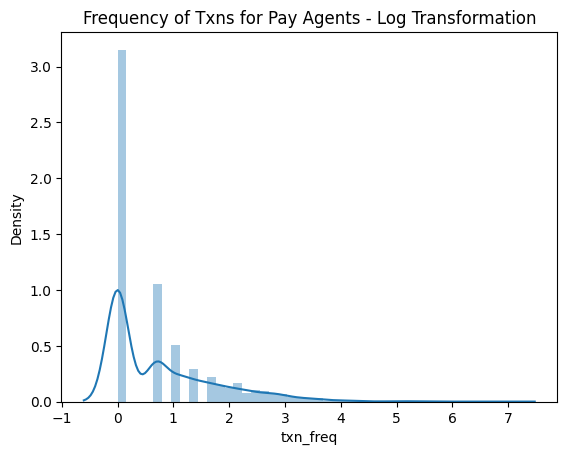

In [260]:
sns.distplot(np.log(pay_agent_freq['txn_freq']))
plt.title("Frequency of Txns for Pay Agents - Log Transformation");

In [261]:
send_agent_freq = pd.DataFrame(df.groupby('Send Agent Name_').count()['Send DateTime'])
send_agent_freq.columns = ['txn_freq']
send_agent_freq.sort_values(by='txn_freq', ascending=False).head(5)

,txn_freq
Send Agent Name_,
agent_11,10468
agent_39,291
agent_2792,18
agent_667,12
agent_2683,11


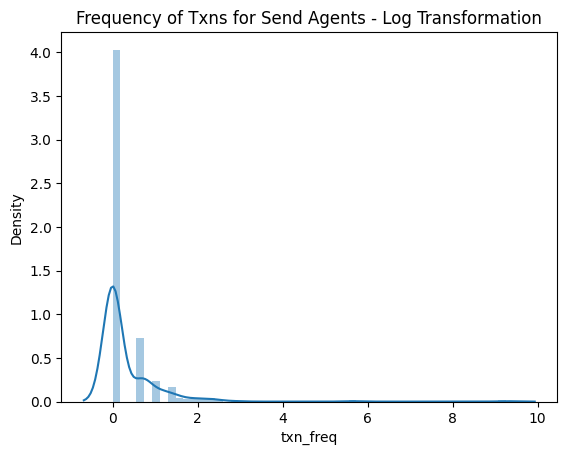

In [262]:
sns.distplot(np.log(send_agent_freq['txn_freq']))
plt.title("Frequency of Txns for Send Agents - Log Transformation");

### Send and Pay Locations

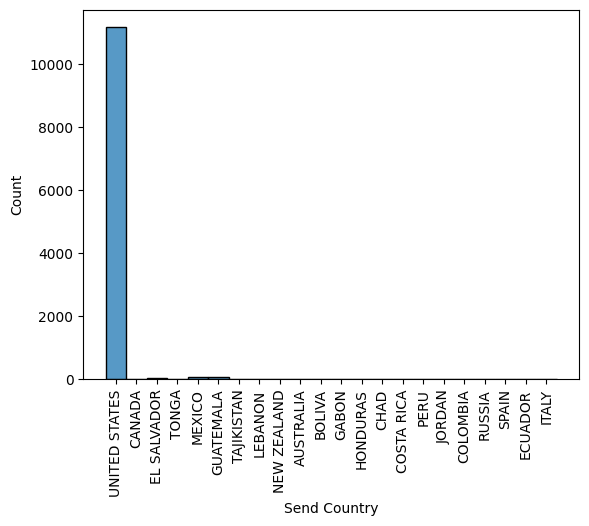

In [579]:
sns.histplot(df['Send Country'])
plt.xticks(rotation=90);

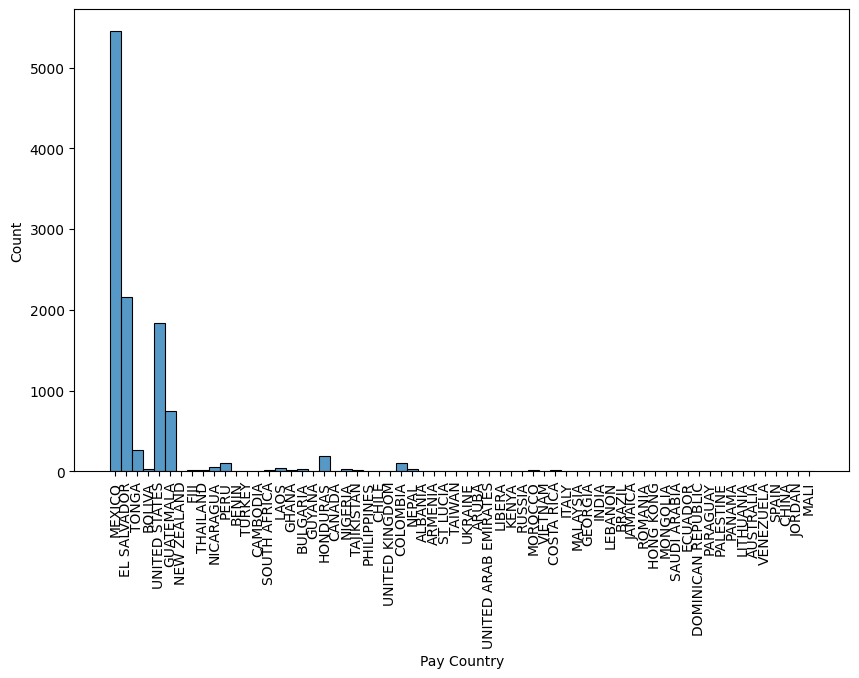

In [581]:
plt.figure(figsize=(10, 6))  # Adjust width as needed, height is optional

sns.histplot(df['Pay Country'])
plt.xticks(rotation=90);

Here, we see users are using this service to primarily send money out of the country, potentially to family members back in Latin America.

## Wiring and recieving transactions

In [264]:
date_format = '%m/%d/%Y %H:%M'
df_time = df.dropna(subset=['Pay DateTime'])
df_time['Send DateTime_DT'] = df_time['Send DateTime'].apply(lambda x: datetime.strptime(x, date_format))
df_time['Pay DateTime_DT'] = df_time['Pay DateTime'].apply(lambda x: datetime.strptime(x, date_format))

In [265]:
df_time['wire_recieve_diff'] = df_time['Pay DateTime_DT'] - df_time['Send DateTime_DT']

In [266]:
df_time['wire_recieve_diff_minutes'] = df_time['wire_recieve_diff'].apply(lambda x: (x.total_seconds() / 60))

In [267]:
df_time['wire_recieve_diff_minutes'].sort_values(ascending = True)

2272          0.0
6037          0.0
2916          0.0
336           0.0
7478          0.0
           ...   
5499      49492.0
928       57468.0
3960      62068.0
10316    130990.0
3575     988391.0
Name: wire_recieve_diff_minutes, Length: 11388, dtype: float64

In [268]:
zero_time = df_time[df_time['wire_recieve_diff_minutes'] == 0]

In [269]:
print(f"There are {len(zero_time)} transactions that were sent and recieved in less than 1 minute")

There are 43 transactions that were sent and recieved in less than 1 minute


This is interesting, these people recieved the money in less than a minute, and are red flags. I will definently keep an eye on these, but will store them in a seperate dataframe so we can spread out the data a little bit with a log transformation.

Text(0.5, 1.0, 'Time between wiring and recieving, log transformation (excluding <0 transactions)')

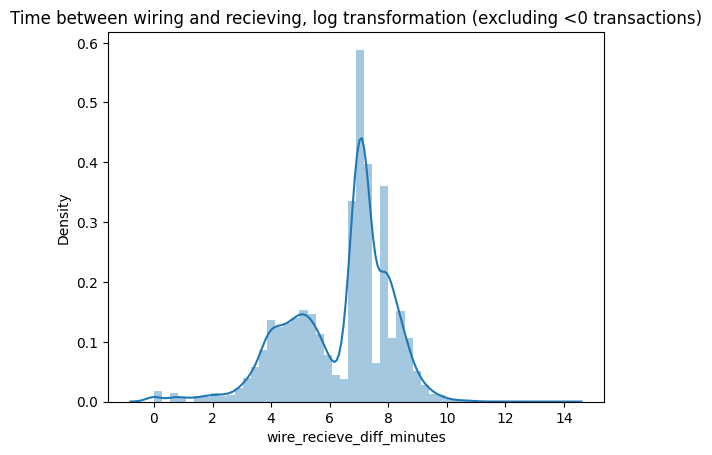

In [270]:
sns.distplot(np.log(df_time[df_time['wire_recieve_diff_minutes'] > 0]['wire_recieve_diff_minutes']))
plt.title("Time between wiring and recieving, log transformation (excluding <0 transactions)")

Text(0.5, 1.0, 'Txn Amount Distribution, Log Transformation')

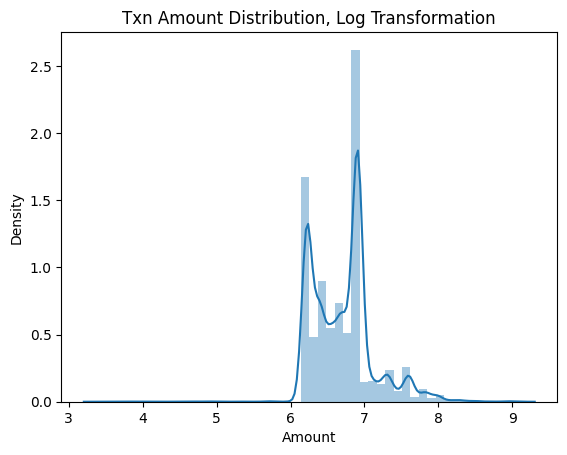

In [271]:
sns.distplot(np.log(df['Amount']))
plt.title("Txn Amount Distribution, Log Transformation")

### Analyze multiple different addresses from same user

## Explanation and Thoughts

After doing a little EDA on the dataset, a few things stand out. I chose to perform log transformations on most distributions to spread out the data. This allows for the data to be more "normal" which will aid when finding outliers, and allows us to view the data in a better spread. 

Most distributions have long tails, indicating the presence of outliers. All of the distributions with long tails are features in which the HIGH outliers are of interest ie. transaction frequency and transaction amount. Our wiring and receiving outliers will be on the left tail, indiciting fast transaction times. This spread isn't as large. 

Now, to confidently identify suspcicious individuals, I will find the outliers in each feature using a few different methods. Then, my plan is to find individuals who are outliers in all of the metrics, and recommend those for further investigation. 

The metrics I will use are: 

1. Transaction size - flag transactions with outlier size
2. Pay Agent Frequency - flag pay agents with large frequency
3. Send Agent Frequency - flag send agents with large frequency
4. Wiring Time - flag agents with low wiring time
5. Sender Frequency - flag senders with large frequency
6. Reciever Frequency - flag recievers with large frequency



# Indentifying Outliers - IQR, Isolation Forest

### By Transaction

In [449]:
by_txn = df_time[['Amount', 'Sender Name_', 'Payee Name_', 'wire_recieve_diff_minutes']]
by_txn['log_amount'] = by_txn['Amount'].apply(lambda x: np.log(x)) 
by_txn.head()

,Amount,Sender Name_,Payee Name_,wire_recieve_diff_minutes,log_amount
0,990.0,name_1,name_742,2658.0,6.897705
1,690.0,name_2,name_3020,219.0,6.536692
2,990.0,name_3,name_3021,1304.0,6.897705
3,1000.0,name_4,name_2609,124.0,6.907755
4,830.0,name_5,name_3022,60.0,6.721426


I apply a log transformation because Isolation Forests work better on Gaussian data. I will now find how much data is an outlier by IQR to determine a reasonable contamination parameter for my Isolation Forest

In [450]:
def IQR_outlier(col_name, df):
    data = df[col_name]
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    print(f"lower bound: {lower_bound}")
    print(f"upper bound: {upper_bound}")
    outliers = df[(df[col_name] < lower_bound) | (df[col_name] > upper_bound)]
    return outliers

In [451]:
outliers = IQR_outlier("log_amount", by_txn)

lower bound: 5.583901755061227
upper bound: 7.7020673933346835


In [452]:
greater_than_zero = df_time[df_time['wire_recieve_diff_minutes'] > 0]
greater_than_zero['log_time'] = greater_than_zero['wire_recieve_diff_minutes'].apply(lambda x: np.log(x))

In [453]:
outliers = IQR_outlier("log_time", greater_than_zero)
np.exp(1.5815397345079658)

lower bound: 1.5815397345079658
upper bound: 10.963744250017921


4.862436912211303

In [454]:
def isoForestDf(features, df, c = 'auto'):
    X_train = df[features]
    clf = IsolationForest(contamination=c)
    clf.fit(X_train)
    outliers = clf.predict(X_train)
    df['outliers'] = outliers

In [455]:
beta_contamination = len(outliers) / len(df)

In [456]:
X_train = by_txn[['log_amount']]
clf = IsolationForest(contamination='auto')
clf.fit(X_train)
outliers = clf.predict(X_train)
by_txn['outlier'] = outliers
filtered_data_txn = by_txn[(by_txn['outlier'] == -1) & (by_txn['wire_recieve_diff_minutes'] < 5)]

filtered_data_txn

,Amount,Sender Name_,Payee Name_,wire_recieve_diff_minutes,log_amount,outlier
15,1429.00,name_10,name_58,1.0,7.264730,-1
199,1122.00,name_10,name_259,1.0,7.022868,-1
266,509.99,name_10,name_2364,0.0,6.234391,-1
403,1515.00,name_10,name_324,1.0,7.323171,-1
542,2550.00,name_10,name_633,2.0,7.843849,-1
...,...,...,...,...,...,...
10065,2347.00,name_10,name_2727,2.0,7.760893,-1
10705,509.99,name_10,name_813,2.0,6.234391,-1
10769,512.50,name_10,name_2865,2.0,6.239301,-1
10875,1460.00,name_10,name_2994,2.0,7.286192,-1


In [457]:
filtered_data_txn['Sender Name_'].unique()

array(['name_10', 'name_2043'], dtype=object)

The dataset filtered_data includes all individuals with an outlier amount, and the transaction was recieved in less than 5 minutes, because the lower bound of our IQR of the log of the difference between wire recieved and wire accepted, then exponentiated to get back the original time, was 5. I originally did a multivariate IsolationTree, but using our domain knowledge, we only really want to isolate transactions with a very small transaction wait period. We see only two names showing up, and name_10 shows up a lot.   

### By Individuals 

Now, lets do the same thing, but for individuals instead of transactions. We also have a little bit more information, and can better determine our contamination parameters in a multivariate Isolation Forest

In [493]:
pay_agent_freq.columns = ['pay_txn_freq']
send_agent_freq.columns = ['send_txn_freq']

In [494]:
merged_df = pd.merge(df, sender_freq, on='Sender Name_', how='left')
merged_df = pd.merge(merged_df, payee_freq, on='Payee Name_', how='left')
merged_df = pd.merge(merged_df, pay_agent_freq, on='Pay Agent Name_', how='left')
merged_df = pd.merge(merged_df, send_agent_freq, on='Send Agent Name_', how='left')

In [495]:
feat = merged_df[['Sender Name_', 'Payee Name_', 'Pay Agent Name_','Send Agent Name_','payee_freq', 'pay_txn_freq', 'send_txn_freq', 'sent_freq']]

In [496]:
feat = feat.reset_index()

In [497]:
feat.columns = ['txn_id', 'Sender Name_', 'Payee Name_', 'Pay Agent Name_','Send Agent Name_','payee_freq', 'pay_txn_freq', 'send_txn_freq', 'sent_freq']

In [498]:
X_train = feat[['payee_freq', 'pay_txn_freq', 'send_txn_freq', 'sent_freq']]
clf = IsolationForest(contamination=.005)
clf.fit(X_train)
outliers = clf.predict(X_train)
feat['outlier'] = outliers
outlier_feat = feat[feat['outlier'] == -1]

In [499]:
print(f"Number of suspicious senders: {len(outlier_feat['Sender Name_'].unique())}")
print(f"Total senders in dataset: {len(df['Sender Name_'].unique())}")
list(outlier_feat['Sender Name_'].unique())

Number of suspicious senders: 3
Total senders in dataset: 3019


['name_10', 'name_1968', 'name_2748']

In [500]:
print(f"Number of suspicious payees: {len(outlier_feat['Payee Name_'].unique())}")
print(f"Total payees in dataset: {len(df['Payee Name_'].unique())}")
list(outlier_feat['Payee Name_'].unique())

Number of suspicious payees: 13
Total payees in dataset: 4658


['name_58',
 'name_247',
 'name_191',
 'name_1119',
 'name_309',
 'name_261',
 'name_1706',
 'name_4059',
 'name_5257',
 'name_195',
 'name_2401',
 'name_3558',
 'name_2336']

In [501]:
print(f"Number of suspicious pay agents: {len(outlier_feat['Pay Agent Name_'].unique())}")
print(f"Total pay agents in dataset: {len(df['Pay Agent Name_'].unique())}")
list(outlier_feat['Pay Agent Name_'].unique())

Number of suspicious pay agents: 1
Total pay agents in dataset: 2519


['agent_11']

In [502]:
print(f"Number of suspicious send agents: {len(outlier_feat['Send Agent Name_'].unique())}")
print(f"Total send agents in dataset: {len(df['Send Agent Name_'].unique())}")
list(outlier_feat['Send Agent Name_'].unique())

Number of suspicious send agents: 5
Total send agents in dataset: 398


['agent_39', 'agent_246', 'agent_667', 'agent_2050', 'agent_2792']

## Analysis

I chose to take a multivariate approach on the frequency to better understand the full picture of our data, and not ommit or include any users who were only suspicious in one way. I chose to omit amount and time between wiring and recieving from the second analysis as I feared it would overpower the importance of these features. 


Given the following analysis, it appears that 'name_10', and perhaps 'name_2043' are both suspicious senders, judging by their fast wiring and recieving time, and frequency of transaction. 'Agent 11' appears to be the most suspicious pay agent, and 'agent 39' and 'agent 246' are the most suspicious send agents. 

In the interest of time, I will explore the sender 'name_10' more in depth, as they demonstrated outlier transaction sizes, high, outlier transaction frequency, fast wire and recieve times, and their pay agent also set off red flags. Their reciever/payee recieved money at the same exact Pay Agent every single time, which is very suspicious. They also use the same Send Agent every single time. 

This is highly suspcicious because all of these transactions are going into the US, and is potentially the "Front" of the operation. They don't keep money at these locations, which they are possibly trying to display as suppliers, for very long, almost immediately recieving the money. 

Additionally, most of their transactions are being sent internationally, mostly to Latin America, but to many different other countries around the world. This is odd for a flower shop. They are most likely using name_10 as a front to show that they are a "business" in the US, but in reality they are recieving money from the US and sending it to Latin America ve

In [525]:
df[df['Sender Name_'] == 'name_10']['Payee Name_'].unique()[:20]
print(f"Total unique recievers: {len(df[df['Sender Name_'] == 'name_10']['Payee Name_'].unique())}")
print(f"Total transactions: 301")

Total unique recievers: 246
Total transactions: 301


Here, we can see that they are sending money to many different entities, which is a red flag as the user is distributing their money to many different agents, in potentially an attempt at disguising it's origin. If, for example, the sender was paying employees, we would see a more consistent reciever profile. However, the Pay and Send agents are all identical, which is suspicious. Perhaps this is a payment location where employees can pick up their salary.

In [522]:
user_10 = df_time[df_time['Sender Name_'] == 'name_10']

<BarContainer object of 301 artists>

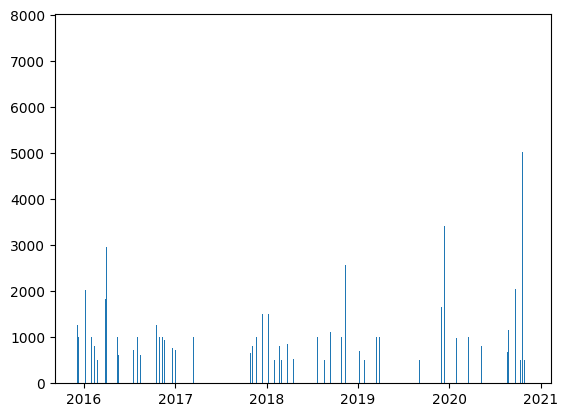

In [524]:
plt.bar(user_10['Send DateTime_DT'], user_10['Amount'])

We can see that these wires of money are not consistent over time, suggesting it is not some kind of payroll.

# Part 2

### 1. 

I will continue to use user_10 as an example for this question. user_10 does not provide an ID number so that is off the table. However, we see that his most payed payee does include an ID, as do many of the other recipients. We could use this to create an array of associated ID's, and find information about these payees so further uncover information about user_10. 

In [ ]:
user_10.groupby("Payee Address_").count()['Send DateTime'].sort_values(ascending=False).head(5)

Payee Address_
address_231     6
address_1490    5
address_57      4
address_423     4
address_192     4
Name: Send DateTime, dtype: int64

In [ ]:
df[df['Payee Address_'] == 'address_231']['Payee ID1 info'].head(1)

1355    1
Name: Payee ID1 info, dtype: int64

In [ ]:
user_10['Pay Agent Name_'].head(1)

10    agent_11
Name: Pay Agent Name_, dtype: object

In [ ]:
user_10['Send Agent Name_'].head(1)

10    agent_39
Name: Send Agent Name_, dtype: object

Additionally, we have the Pay and Send Agent Name as "agent_11" and "agent_39". This user sends money from, and has the recipients recieve money, from the exact same location very time, allowing us to find who the business is registered too, and identify if this is a legitamate "flower" business or not.

## 2. 

If I were to format these results to a jury/commanding officers, I would first explain the concept of outliers, and then display a few, NON log normalized histograms (with count on the y axis). I would explain how most of their transactions in this "normal" range are going abroad, whereas the outliers are the only transactions staying in the US. I would explain how, for a flower shop, you would expect that they would have more US based costs, even if they were importing flowers from Latin America. Additionally, all US expenses are recieved less than a minute after they are sent, indicating they want this money to exit the US banking system as fast as possible. I would explain how there is only 1 US location that they send lots of money too, and it is only coming from one sender in their data. I would recommend commanding officers to set up in the recieving location of user_10's payments, and to investigate if this is a legitamite business or not. I would also recommend we further investigate the send addresses of these international transactions, and determine if these are flower business entities or not. 